<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

In [42]:
import  warnings
import  phitter
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
import  statsmodels.api                             as      sm
from    scipy.stats                                 import  norm, johnsonsu, johnsonsb, lognorm, kstest, anderson, skew, kurtosis
from    scipy.special                               import  eval_genlaguerre
from    sklearn.linear_model                        import  LinearRegression, Ridge, HuberRegressor
from    math                                        import  sqrt, exp
from    j_johnson_M                                 import  f_johnson_M
from    statsmodels.stats.diagnostic                import  normal_ad
from    statsmodels.nonparametric.kernel_regression import  KernelReg

np.random.seed(0)
plt.style.use('ggplot')

In [43]:
color_jlsmc = 'blue'
color_invalid = 'red'

In [44]:
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
alpha       = 0.99
K           = 95
order_mom   = 4

In [45]:
def beta(t):
    return np.exp(-r*t)

def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

def get_mu2(mu1, mu2_raw):
    return mu2_raw - mu1**2
def get_mu3(mu1, mu2_raw, mu3_raw):
    return mu3_raw - 3*mu1*mu2_raw - mu1**3
def get_mu4(mu1, mu2_raw, mu3_raw, mu4_raw):
    return mu4_raw - 4*mu1*mu3_raw + 6*mu2_raw*mu1**2 - 3*mu1**4
def get_centred_moms(mu1, mu2_raw, mu3_raw, mu4_raw):
    mu2 = get_mu2(mu1, mu2_raw)
    mu3 = get_mu3(mu1, mu2_raw, mu3_raw)
    mu4 = get_mu4(mu1, mu2_raw, mu3_raw, mu4_raw)
    return mu2, mu3, mu4
def get_skew(mu3, mu2):
    return mu3 / mu2**(3/2)
def get_kurt(mu4, mu2):
    return mu4 / mu2**2

In [46]:
S_paths         = gen_S(S0, M, N)
mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtm_diff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_func        = np.linspace(np.min(mtm_paths[:, ind_tref]), np.max(mtm_paths[:, ind_tref]), 1000)
y_train         = mtm_diff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_mom+1)

In [47]:
Mtest           = 100
Mtest_in        = 100000
S_test          = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), Mtest)

S_paths_nested      = np.zeros((Mtest, Mtest_in, ind_tdelta-ind_tref+1))
mtm_paths_nested    = np.zeros((Mtest, Mtest_in, ind_tdelta-ind_tref+1))
mtm_diff            = np.zeros((Mtest, Mtest_in))
for m in range(Mtest):
    S_paths_nested[m, :, :]     = gen_S(S_test[m], Mtest_in, ind_tdelta-ind_tref)
    mtm_paths_nested[m, :, :]   = gen_mtm_put(S_paths_nested[m, :, :], time_grid[ind_tref:ind_tdelta+1])
    mtm_diff[m, :]              = mtm_paths_nested[m, :, -1] - mtm_paths_nested[m, :, 0]
mtm_test = mtm_paths_nested[:, 0, 0]

mu1raw_test = np.mean(mtm_diff, axis=1)
mu2raw_test = np.mean(mtm_diff**2, axis=1)
mu3raw_test = np.mean(mtm_diff**3, axis=1)
mu4raw_test = np.mean(mtm_diff**4, axis=1)
mu2_test, mu3_test, mu4_test = get_centred_moms(mu1raw_test, mu2raw_test, mu3raw_test, mu4raw_test)
skew_test   = get_skew(mu3_test, mu2_test)
kurt_test   = get_kurt(mu4_test, mu2_test)

In [48]:
def training_pipeline(setting):
    yhat_test   = np.zeros((len(mtm_test), order_mom+1))
    yhat_func   = np.zeros((len(mtm_func), order_mom+1))
    method      = setting['method']

    if (method == 'LR') or (method == 'HR') or (method == 'GLM'):
        S       = setting['S']
        X_train = np.column_stack([eval_genlaguerre(s, 0, mtm_paths[:, ind_tref]) for s in range(S+1)])
        X_test  = np.column_stack([eval_genlaguerre(s, 0, mtm_test) for s in range(S+1)])
        X_func  = np.column_stack([eval_genlaguerre(s, 0, mtm_func) for s in range(S+1)])
        #X_train = np.column_stack([ mtm_paths[:, ind_tref]**s for s in range(S+1)])
        #X_test  = np.column_stack([mtm_test**s for s in range(S+1)])
        #X_func  = np.column_stack([mtm_func**s for s in range(S+1)])
        model   = LinearRegression(fit_intercept=False)
        for j in range(1, order_mom+1):
            if j%2 != 0:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(setting['ridge'], fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'], fit_intercept=False)
                elif (method == 'LR') or (method == 'GLM'):
                    model = LinearRegression(fit_intercept=False)
                
                model.fit(X_train, y_train[:, j-1])
                yhat_test[:, j-1]   = model.predict(X_test)
                yhat_func[:, j-1]   = model.predict(X_func)
            else:
                if (method == 'LR') and (setting['ridge']>0):
                    model = Ridge(alpha=setting['ridge'], fit_intercept=False)
                elif method == 'LR':
                    model = LinearRegression(fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=setting['epsilon'], alpha=setting['ridge'] ,fit_intercept=False)
                elif (method == 'GLM') and (setting['ridge']>0):
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.log())).fit_regularized(method='elastic_net', alpha=setting['ridge'], L1_wt=0)
                elif method == 'GLM':
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.log())).fit()
                
                if method != 'GLM':
                    model.fit(X_train, y_train[:, j-1])

                yhat_test[:, j-1]   = model.predict(X_test)
                yhat_func[:, j-1]   = model.predict(X_func)
    
    elif method =='KR':

        X_train = mtm_paths[:, ind_tref].reshape(-1, 1)
        iqr     = np.quantile(mtm_paths[:, ind_tref], 0.75) - np.quantile(mtm_paths[:, ind_tref], 0.25)
        slvm    = 0.9*min(np.std(mtm_paths[:, ind_tref]), iqr/1.34) * len(mtm_paths[:, ind_tref])**(-1/5)
        X_test  = mtm_test.reshape(-1, 1)
        X_func  = mtm_func.reshape(-1, 1)
        for j in range(1, order_mom+1):
            kr                  = KernelReg(endog=y_train[:, j-1], exog=X_train, var_type='c', bw=[slvm])
            yhat_test[:, j-1]   = kr.fit(X_test)[0]
            yhat_func[:, j-1]   = kr.fit(X_func)[0]
    
    return yhat_test, yhat_func

In [ ]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'S': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'S': 4},
    {'id': 2, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'S': 2},
    {'id': 3, 'method': 'GLM', 'ridge': 0, 'S': 2},
    {'id': 4, 'method': 'GLM', 'ridge': 0, 'S': 4},
    {'id': 5, 'method': 'KR'}
]

In [58]:
setting = settings_list[3]
yhat_test, yhat_func = training_pipeline(setting)

mu1rawhat_test, mu2rawhat_test, mu3rawhat_test, mu4rawhat_test = yhat_test[:, 0], yhat_test[:, 1], yhat_test[:, 2], yhat_test[:, 3]
mu1rawhat_func, mu2rawhat_func, mu3rawhat_func, mu4rawhat_func = yhat_func[:, 0], yhat_func[:, 1], yhat_func[:, 2], yhat_func[:, 3]

mu2hat_test, mu3hat_test, mu4hat_test   = get_centred_moms(mu1rawhat_test, mu2rawhat_test, mu3rawhat_test, mu4rawhat_test)
mu2hat_func, mu3hat_func, mu4hat_func   = get_centred_moms(mu1rawhat_func, mu2rawhat_func, mu3rawhat_func, mu4rawhat_func)

mask_mu2hat_test = (mu2rawhat_test>0)&(mu2hat_test>0)
mask_mu2hat_func = (mu2rawhat_func>0)&(mu2hat_func>0)

mask_mu3hat_test = (mu2rawhat_test>0)
mask_mu3hat_func = (mu2rawhat_func>0)

mask_mu4hat_test = (mu4rawhat_test>0)&(mu2rawhat_test>0)&(mu4hat_test>0)
mask_mu4hat_func = (mu4rawhat_func>0)&(mu2rawhat_func>0)&(mu4hat_func>0)

skewhat_test = get_skew(mu3hat_test[mask_mu2hat_test], mu2hat_test[mask_mu2hat_test])
kurthat_test = get_kurt(mu4hat_test[mask_mu4hat_test], mu2hat_test[mask_mu4hat_test])
skewhat_func = get_skew(mu3hat_func[mask_mu2hat_func], mu2hat_func[mask_mu2hat_func])
kurthat_func = get_kurt(mu4hat_func[mask_mu4hat_func], mu2hat_func[mask_mu4hat_func])

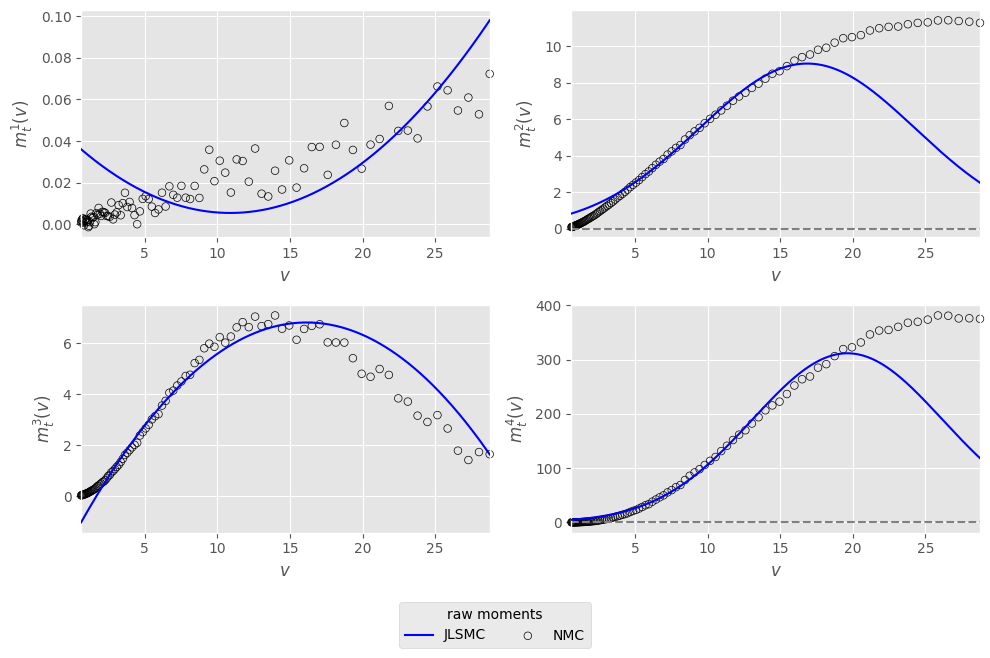

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, mu1rawhat_func, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, mu2rawhat_func, color=color_jlsmc, zorder=3)
axs[0, 1].scatter(mtm_test, mu2raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, mu3rawhat_func, color=color_jlsmc, zorder=3)
axs[1, 0].scatter(mtm_test, mu3raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, mu4rawhat_func, color=color_jlsmc, zorder=3)
axs[1, 1].scatter(mtm_test, mu4raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
plt.show()

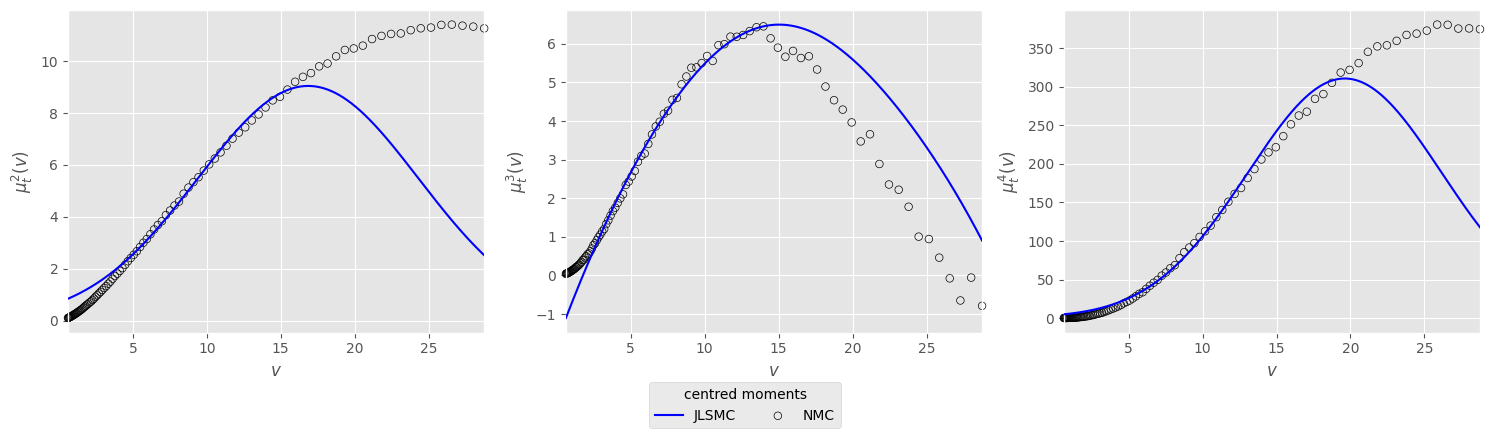

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[mask_mu2hat_func], mu2hat_func[mask_mu2hat_func], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_mu3hat_func], mu3hat_func[mask_mu3hat_func], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_test, mu3_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_mu4hat_func], mu4hat_func[mask_mu4hat_func], color=color_jlsmc, zorder=3)
axs[2].scatter(mtm_test, mu4_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
plt.show()

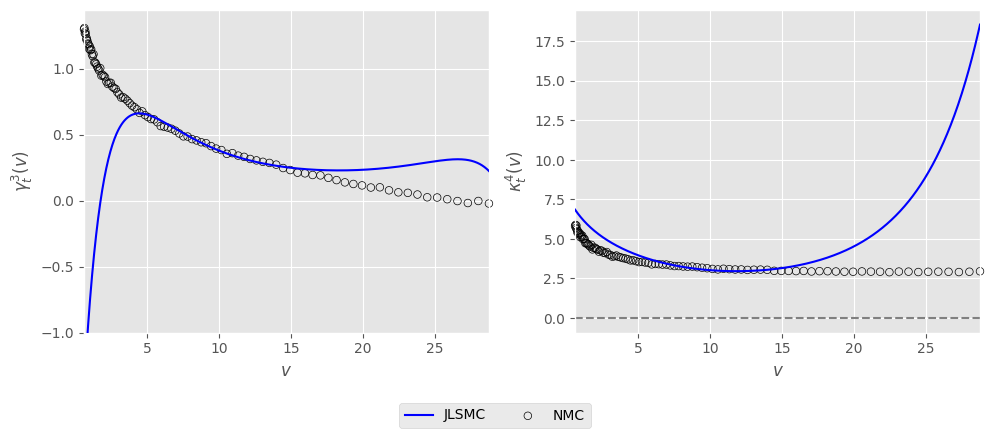

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_mu2hat_func], skewhat_func, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t^3(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_mu4hat_func], kurthat_func, color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t^4(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()